<a href="https://colab.research.google.com/github/gvaccaro2020/data_science_projects/blob/master/Artificia_Intelligence_CCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![BTS](https://github.com/vfp1/bts-mbds-data-science-foundations-2019/raw/master/sessions/img/Logo-BTS.jpg)

# Artificial Intelligence: final project
# Implementation of a various Network achitectures using the Fashion MNIST dataset
### Giuseppe Vaccaro 


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook as tqdm
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import time

### The Fashion MNIST dataset is available in torchvision, and contains a total of 70000 fashion images

### Before loading the dataset in the notebook and transformig images into Tensor using Transform.Tensor, a function is going to be implemented in order to split the daset into train and  validation 

In [0]:
device = torch.device("cuda")

In [0]:
import logging
from functools import lru_cache

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np

class DataSplit:

    def __init__(self, dataset, test_train_split=1, val_train_split=0.2, shuffle=False):
        self.dataset = dataset

        #check the dimension of the image in the dataset

        print('Dimension of the images')
        print(self.dataset[0][0].shape)
        print(" ")
        
        #check the number of classes in the dataset

        print('The dataset contains', (len(self.dataset.classes)),'','classes')
        print(" ")

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[ : validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)

        print('length of Train set is', len(self.train_indices))
        print('length of Validation set is', len(self.val_indices))

        #display 20 random images from the dataset

        random_images=torch.LongTensor(20).random_(0, len(dataset))
        plt.figure(figsize=(10,10))
        for num in range(len(random_images)):
          img, _ = dataset[random_images[num]]
          plt.subplot(4, 5, num+1)
          plt.imshow(img.numpy()[0])
        plt.tight_layout()
        plt.show

    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    def return_lenghts_datasets(self):
        return len(self.train_indices), len(self.val_indices)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=50, num_workers=4):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing train dataloader')
        self.train_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing validation dataloader')
        self.val_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing test dataloader')
        self.test_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader


In [15]:
transform = transforms.ToTensor()

train_validation_set = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)

test_set = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Lenght of the Test set: 10000
 
Dimension of the images
torch.Size([1, 28, 28])
 
The dataset contains 10  classes
 
length of Train set is 48000
length of Validation set is 12000





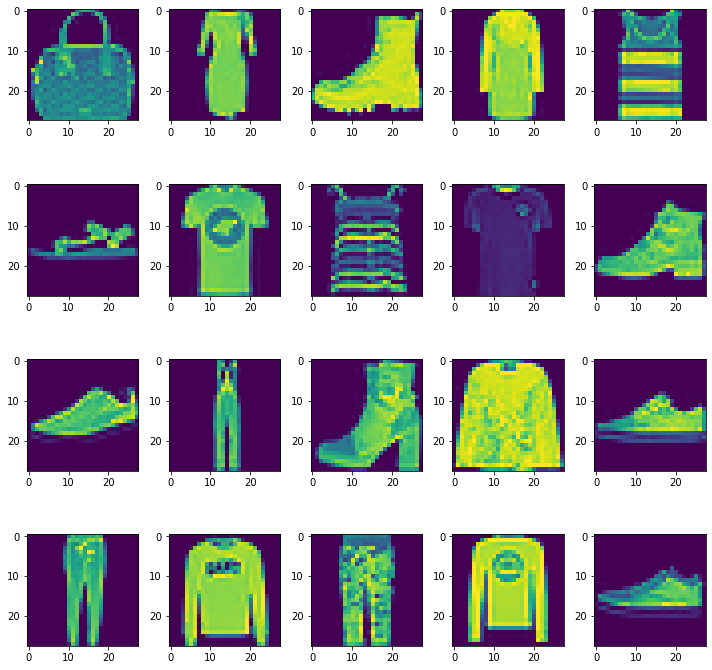

In [16]:
print('Lenght of the Test set:', len(test_set))
print(' ')
split = DataSplit(train_validation_set, shuffle=True)


In [0]:
train_loader, val_loader, test_loader = split.get_split(batch_size=75, num_workers=8)

##Defining the function that will be used for train and Validation of the networks

In [0]:
size_trainset, size_validset = split.return_lenghts_datasets()

def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_epoch(train_loader, network, optimizer, criterion, hparams, epoch):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  losses = []
  accs = []
  for batch_idx, (data, target) in enumerate(train_loader, 1):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      acc = 100 * (correct_predictions(output, target) / data.shape[0])
      losses.append(loss.item())
      accs.append(acc)
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.1f}'.format(
              epoch, batch_idx * len(data), size_trainset,
              100. * batch_idx / len(train_loader), loss.item(),
              acc))
  return np.mean(losses), np.mean(accs)

def eval_epoch(val_loader, network, criterion, hparams):
    network.eval()
    device = hparams['device']
    eval_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            eval_loss += criterion(output, target, reduction='sum').item() # sum up batch loss
            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)
    # Average acc across all correct predictions batches now
    eval_loss /= size_validset
    eval_acc = 100. * acc / size_validset
    print('Eval set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        eval_loss, acc, size_validset, eval_acc,
        ))
    return eval_loss, eval_acc


In [0]:
def train_validate_and_plot(network, train_loader, val_loader, optimizer, criterion, hparams, n_epochs, plot=True):

  tr_losses = []
  tr_accs = []
  val_losses = []
  val_accs = []

  network= network
  optimizer=optimizer
  criterion=criterion
  for epoch in range(1,n_epochs + 1):
    tr_loss, tr_acc = train_epoch(train_loader, network, optimizer, criterion, hparams, epoch)
    val_loss, val_acc = eval_epoch(val_loader, network, criterion, hparams)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    tr_losses.append(tr_loss)
    tr_accs.append(tr_acc)
  metrics = {'tr_losses':tr_losses, 'val_losses':val_losses,
          'tr_accs':tr_accs, 'val_accs':val_accs}

  if plot:
    plt.figure(figsize=(10, 8))
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('NLLLoss')
    plt.plot(tr_losses, label='train')
    plt.plot(val_losses, label='eval')
    plt.legend()
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Eval Accuracy [%]')
    plt.plot(tr_accs, label='train')
    plt.plot(val_accs, label='eval')
    plt.legend()
  return metrics


Defining the hyperparameters that are going to be used when training the networks

In [0]:
import torch.nn.functional as F
hparams = {
    'batch_size':64,
    'num_epochs':20,
    'test_batch_size':64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_interval':100,
}
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

## Implementation of the Network

### Calling a Class named ConvBlock which has the goal of providing a structure to run Convolutions later on when defining the different Network architectures

### ConvBlok runs by default calls a Max Pool layer of 2 by 2

In [0]:
class ConvBlock(nn.Module):

  def __init__(self, num_inp_channels, num_out_fmaps, 
               kernel_size, pool_size=2, stride=1):
    super().__init__()
    # TODO: define the 3 modules needed
    self.conv = nn.Conv2d(num_inp_channels, num_out_fmaps, kernel_size)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(pool_size)
  
  def forward(self, x):
    return self.maxpool(self.relu(self.conv(x)))

## First Network

Given the inputs of images with height, width and depth of respectively 28, 28, and 1, the fist network will perform the following operations:

1. Add a 2d Constantpadding of 2 to the initial imputs, hence transforming the input from 28x28 to 32x32 height and width 

2. Perform a frst convolution with a kernel of 5 x 5, followed by a default max pool layer of 2 by 2.The resulting output dimensions are: 6 output features maps, with height and width of 14 X 14

3. Perform a second convolution with a kernel of 5 x 5, followed by a default max pool layer of 2 by 2. The resulting output dimensions are: 16 output features maps, with height and width of 5 X 5

3. Apply a multilayer perceptron with three hidden layers, that returns, via logSoftmax, a vector of ten elements representing the probabilities distribution for the 10 taget classes



In [0]:
class PseudoLeNet(nn.Module):

  def __init__(self):
    super().__init__()
    # TODO: Define the padding
    self.pad = nn.ConstantPad2d(2, 0)  # [bsz, 1, 32, 32]
    self.conv1 = ConvBlock(1, 6, 5)  # [bsz, 6, 14, 14]
    self.conv2 = ConvBlock(6, 16, 5)  # [bsz, 16, 5, 5]
    # TODO: Define the MLP at the deepest layers
    self.mlp = nn.Sequential(
        nn.Linear(16*5*5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10),
        nn.LogSoftmax(),
    )

  def forward(self, x):
    x = self.pad(x)
    x = self.conv1(x)
    x = self.conv2(x)
    bsz, nch, height, width = x.shape   
    x = torch.flatten(x, start_dim=1) # [bsz, 16*5*5]
    y = self.mlp(x)
    return y


In [22]:
net1= PseudoLeNet()
print(net1)

PseudoLeNet(
  (pad): ConstantPad2d(padding=(2, 2, 2, 2), value=0)
  (conv1): ConvBlock(
    (conv): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ConvBlock(
    (conv): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mlp): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
    (5): LogSoftmax()
  )
)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [7500/48000 (16%)]	Loss: 0.538132	Acc: 80.0
Train Epoch: 1 [15000/48000 (31%)]	Loss: 0.613085	Acc: 78.7
Train Epoch: 1 [22500/48000 (47%)]	Loss: 0.475045	Acc: 84.0
Train Epoch: 1 [30000/48000 (62%)]	Loss: 0.649540	Acc: 74.7
Train Epoch: 1 [37500/48000 (78%)]	Loss: 0.374468	Acc: 85.3
Train Epoch: 1 [45000/48000 (94%)]	Loss: 0.431736	Acc: 85.3
Train Epoch: 1 [48000/48000 (100%)]	Loss: 0.362458	Acc: 88.0
Eval set: Average loss: 0.4189, Accuracy: 10126/12000 (84%)
Train Epoch: 2 [7500/48000 (16%)]	Loss: 0.474072	Acc: 82.7
Train Epoch: 2 [15000/48000 (31%)]	Loss: 0.393824	Acc: 86.7
Train Epoch: 2 [22500/48000 (47%)]	Loss: 0.366609	Acc: 86.7
Train Epoch: 2 [30000/48000 (62%)]	Loss: 0.449599	Acc: 78.7
Train Epoch: 2 [37500/48000 (78%)]	Loss: 0.285264	Acc: 90.7
Train Epoch: 2 [45000/48000 (94%)]	Loss: 0.343452	Acc: 90.7
Train Epoch: 2 [48000/48000 (100%)]	Loss: 0.320504	Acc: 86.7
Eval set: Average loss: 0.3418, Accuracy: 10510/12000 (88%)
Train Epoch: 3 [7500/48000 (16%)]	Loss: 

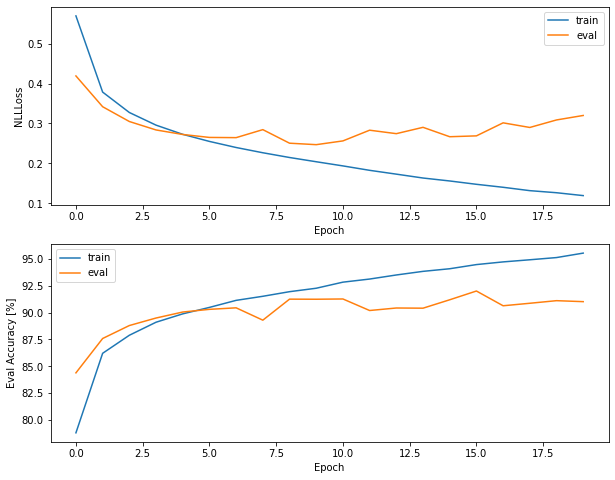

In [24]:
network = PseudoLeNet()
network.to(hparams['device'])
optimizer = optim.RMSprop(network.parameters(), lr=hparams['learning_rate'])
criterion = F.nll_loss

first_net=train_validate_and_plot(network, train_loader, val_loader, optimizer, criterion, hparams, hparams['num_epochs'])

## Second Network

The output of the first network shows that the model is slightly overfitting given that the training loss decreases with every iterations wheras the loss of the validation set seems to peak at the 8th epoch. The same applies to the accuracy, which in the case of the training set it keeps improving with with every iterations, wherease when it comes to the validation set, it peaks around the 15th epoch; this implies that the model, that is performing well on the training set, does not keep the same performance when generalizing on data outside the trainset

In order to reduce overfitting, L2 regularization of 0.001 (which is passed using weight_decay=0.001) and dropout are added to the network, resulting in a network that i have named 'PseudoLeNetwithDropout'


In [0]:
class PseudoLeNetwithDropout(nn.Module):

  def __init__(self, dropout):
    super().__init__()
    # TODO: Define the padding
    self.pad = nn.ConstantPad2d(2, 0)  # [bsz, 1, 32, 32]
    self.conv1 = ConvBlock(1, 6, 5)  # [bsz, 6, 14, 14]
    self.dout1 = nn.Dropout(dropout)
    self.conv2 = ConvBlock(6, 16, 5)  # [bsz, 16, 5, 5]
    # TODO: Define the MLP at the deepest layers
    self.mlp = nn.Sequential(
        nn.Linear(16*5*5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10),
        nn.LogSoftmax(),
    )

  def forward(self, x):
    x = self.pad(x)
    x = self.conv1(x)
    x = self.dout1(x)
    x = self.conv2(x)
    bsz, nch, height, width = x.shape 
    x = torch.flatten(x, start_dim=1) # [bsz, 16*5*5]
    y = self.mlp(x)
    return y

In [26]:
net= PseudoLeNetwithDropout(0.3)
print(net)

PseudoLeNetwithDropout(
  (pad): ConstantPad2d(padding=(2, 2, 2, 2), value=0)
  (conv1): ConvBlock(
    (conv): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dout1): Dropout(p=0.3, inplace=False)
  (conv2): ConvBlock(
    (conv): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mlp): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
    (5): LogSoftmax()
  )
)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [7500/48000 (16%)]	Loss: 0.744881	Acc: 68.0
Train Epoch: 1 [15000/48000 (31%)]	Loss: 0.575600	Acc: 78.7
Train Epoch: 1 [22500/48000 (47%)]	Loss: 0.870006	Acc: 73.3
Train Epoch: 1 [30000/48000 (62%)]	Loss: 0.606535	Acc: 80.0
Train Epoch: 1 [37500/48000 (78%)]	Loss: 0.751996	Acc: 76.0
Train Epoch: 1 [45000/48000 (94%)]	Loss: 0.701447	Acc: 72.0
Train Epoch: 1 [48000/48000 (100%)]	Loss: 0.487378	Acc: 84.0
Eval set: Average loss: 0.5364, Accuracy: 9520/12000 (79%)
Train Epoch: 2 [7500/48000 (16%)]	Loss: 0.407332	Acc: 86.7
Train Epoch: 2 [15000/48000 (31%)]	Loss: 0.536485	Acc: 78.7
Train Epoch: 2 [22500/48000 (47%)]	Loss: 0.371252	Acc: 86.7
Train Epoch: 2 [30000/48000 (62%)]	Loss: 0.487720	Acc: 80.0
Train Epoch: 2 [37500/48000 (78%)]	Loss: 0.430780	Acc: 86.7
Train Epoch: 2 [45000/48000 (94%)]	Loss: 0.509561	Acc: 80.0
Train Epoch: 2 [48000/48000 (100%)]	Loss: 0.457513	Acc: 81.3
Eval set: Average loss: 0.4480, Accuracy: 9951/12000 (83%)
Train Epoch: 3 [7500/48000 (16%)]	Loss: 0.

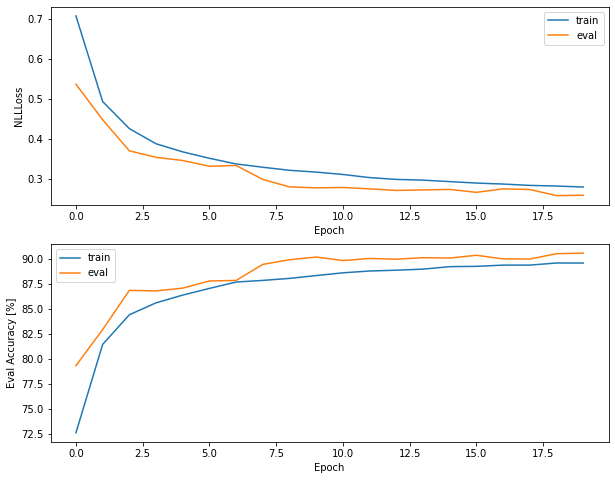

In [27]:
dropout = 0.3
network_dropout = PseudoLeNetwithDropout(dropout)
network_dropout.to(hparams['device'])
optimizer = optim.RMSprop(network_dropout.parameters(), weight_decay=0.001, lr=hparams['learning_rate']) 

second_net=train_validate_and_plot(network_dropout, train_loader, val_loader, optimizer, criterion, hparams, hparams['num_epochs'])

##Third Network

the PseudoLeNetwithDropout (which includes with regularizers L2 and droput) provides very satisfying results: the network seems to generalize quite well, as we can see from loss and accuracy on the validation set. Furthermore, accuracy is quite high in both train and validaton set, and the model overall seems to perform quite well in mininizing loss

We can nevertheless try to improve the performance of the network further by implementing a third mode, which I am going to name BigNetDropout; the architecture of the model works as follows:

1. Performs a frst convolution with a kernel of 5 x 5, a stride of 2, followed by a default max pool layer of 2 by 2. The resulting output dimensions are:  512 output features maps, with height and width of 12 X 12

2. Performs a second convolution with a kernel of 3 x 3, followed by a default max pool layer of 2 by 2. The resulting output dimensions are: 1024 output features maps, with height and width of 5 X 5

3. Apply a multilayer perceptron with three hidden layers, that returns via logSoftmax a vector of ten elements representing the probabilities distribution for the 10 taget classes

In [0]:
class BigNetDropout(nn.Module):

  def __init__(self, dropout):
    super().__init__()
    self.conv1 = ConvBlock(1, 512, 5, stride=2) #[bsz, 512, 12, 12]
    self.dout1 = nn.Dropout(dropout)
    self.conv2 = ConvBlock(512, 1024, 3) #[bsz, 1024, 5, 5]
    self.mlp = nn.Sequential(
        nn.Linear(1024 * 5 * 5, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout),
        nn.Linear(1024, 10),
        nn.LogSoftmax(dim=-1)
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.dout1(x)
    x = self.conv2(x)
    bsz, nch, height, width = x.shape
    x = x.view(bsz, -1)
    y = self.mlp(x)
    return y

In [33]:
net=BigNetDropout(0.4)
print(net)

BigNetDropout(
  (conv1): ConvBlock(
    (conv): Conv2d(1, 512, kernel_size=(5, 5), stride=(1, 1))
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dout1): Dropout(p=0.4, inplace=False)
  (conv2): ConvBlock(
    (conv): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mlp): Sequential(
    (0): Linear(in_features=25600, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
    (4): LogSoftmax()
  )
)


Train Epoch: 1 [7500/48000 (16%)]	Loss: 0.555961	Acc: 77.3
Train Epoch: 1 [15000/48000 (31%)]	Loss: 0.462348	Acc: 84.0
Train Epoch: 1 [22500/48000 (47%)]	Loss: 0.618352	Acc: 78.7
Train Epoch: 1 [30000/48000 (62%)]	Loss: 0.303848	Acc: 90.7
Train Epoch: 1 [37500/48000 (78%)]	Loss: 0.472874	Acc: 84.0
Train Epoch: 1 [45000/48000 (94%)]	Loss: 0.521118	Acc: 85.3
Train Epoch: 1 [48000/48000 (100%)]	Loss: 0.395532	Acc: 85.3
Eval set: Average loss: 0.3383, Accuracy: 10511/12000 (88%)
Train Epoch: 2 [7500/48000 (16%)]	Loss: 0.301395	Acc: 85.3
Train Epoch: 2 [15000/48000 (31%)]	Loss: 0.354142	Acc: 89.3
Train Epoch: 2 [22500/48000 (47%)]	Loss: 0.291832	Acc: 84.0
Train Epoch: 2 [30000/48000 (62%)]	Loss: 0.248050	Acc: 92.0
Train Epoch: 2 [37500/48000 (78%)]	Loss: 0.351394	Acc: 88.0
Train Epoch: 2 [45000/48000 (94%)]	Loss: 0.475835	Acc: 85.3
Train Epoch: 2 [48000/48000 (100%)]	Loss: 0.275430	Acc: 89.3
Eval set: Average loss: 0.3141, Accuracy: 10600/12000 (88%)
Train Epoch: 3 [7500/48000 (16%)]	Loss: 

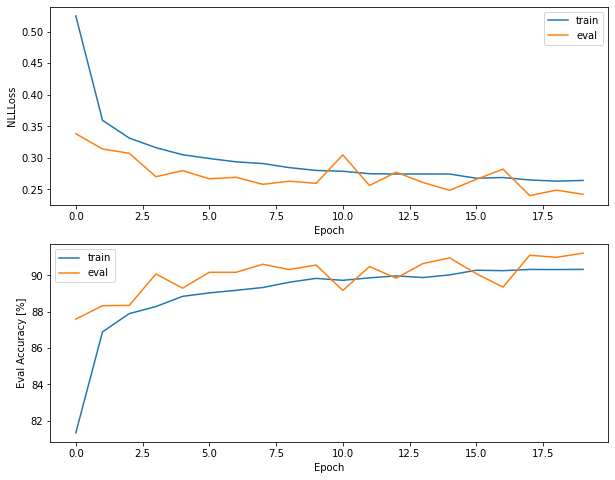

In [30]:
dropout= 0.4
newnetwork = BigNetDropout(dropout)
newnetwork.to(hparams['device'])
optimizer = optim.Adam(newnetwork.parameters(),  weight_decay=0.001, lr=hparams['learning_rate']) 

third_net=train_validate_and_plot(newnetwork, train_loader, val_loader, optimizer, criterion, hparams, hparams['num_epochs'])

Also this model generlzes quite well, as we can seem from the accuracy and loos of the validation sets which keeps improving per each iteration. Accuracy and loss are quite high on both training and validation

##We can now test the BigNetDropout (the model that so far has given the best results) using the unseen observation of the test set

In [0]:
def test_epoch(test_loader, network, criterion, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += criterion(output, target, reduction='sum').item() # sum up batch loss
            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)
    # Average acc across all correct predictions batches now
    test_loss /= len(test_set)
    test_acc = 100. * acc / len(test_set)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, acc, len(test_set), test_acc,
        ))
    return test_loss, test_acc

In [37]:
test_loader = DataLoader(test_set, batch_size=50, shuffle=False, num_workers=4)
dropout= 0.4
newnetwork = BigNetDropout(dropout)
newnetwork.to(hparams['device'])
optimizer = optim.Adam(newnetwork.parameters(),  weight_decay=0.001, lr=hparams['learning_rate']) 

test_model= test_epoch(test_loader, network, criterion, hparams)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test set: Average loss: 0.3550, Accuracy: 9022/10000 (90%)
